Generative Adverserial Networks in PyTorch
Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a

Define the problem statement
Load the data (with transforms and normalization)
Denormalize for visual inspection of samples
Define the Discriminator network
Study the activation function: Leaky ReLU
Define the Generator network
Explain the output activation function: TanH
Look at some sample outputs
Define losses, optimizers and helper functions for training
For discriminator
For generator
Train the model
Save intermediate generated images to file
Look at some outputs
Save the models

In [11]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST

mnist =MNIST(root='data',
             train=True,
             download=True,
             transform=Compose([ToTensor(),Normalize(mean=(0.5,),std=(0.5))]))

In [12]:
img,label =mnist[0]
print('Label:',label)
print(img[:,10:15,10:15])
torch.min(img),torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [13]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1)

Label: 5


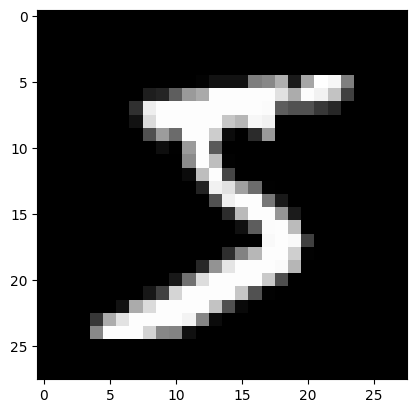

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
img_norm =denorm(img)
plt.imshow(img_norm[0],cmap='gray')
print('Label:',label)

In [15]:
from torch.utils.data import DataLoader

batch_size =100
data_loader =DataLoader(mnist,batch_size,shuffle =True)

first batch
torch.Size([100, 1, 28, 28])
tensor([7, 2, 8, 7, 7, 7, 8, 7, 2, 1, 6, 4, 7, 4, 8, 3, 5, 0, 2, 7, 7, 8, 0, 3,
        2, 0, 2, 2, 5, 5, 7, 1, 3, 8, 8, 5, 0, 1, 7, 1, 1, 8, 5, 0, 8, 5, 7, 6,
        5, 2, 0, 6, 5, 7, 1, 5, 2, 3, 8, 7, 5, 1, 3, 1, 4, 5, 6, 3, 9, 4, 3, 0,
        3, 3, 0, 3, 0, 3, 5, 2, 8, 2, 9, 0, 5, 7, 2, 6, 3, 8, 2, 1, 8, 3, 7, 9,
        9, 2, 3, 3])


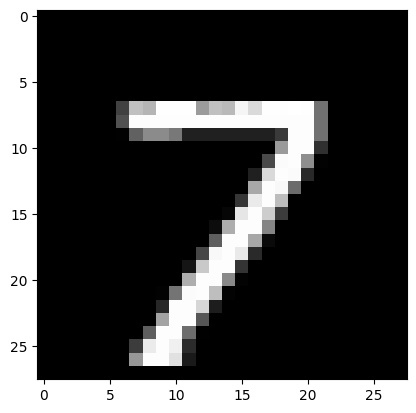

In [16]:
for img_batch,label_batch in data_loader:
  print('first batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0],cmap='gray')
  print(label_batch)
  break

In [17]:
import tensorflow as tf
device= tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


In [18]:
#Device
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Discriminator Network

In [19]:
image_size =784
hidden_size =256

In [20]:
import torch.nn as nn
D= nn.Sequential(
   nn.Linear(image_size,hidden_size),
   nn.LeakyReLU(0.2),
   nn.Linear(hidden_size,hidden_size),
   nn.LeakyReLU(0.2),
   nn.Linear(hidden_size,1),
   nn.Sigmoid()
)

In [21]:
D.to(device);

In [22]:
latent_size =64

In [23]:
G=nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()
)

In [24]:
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

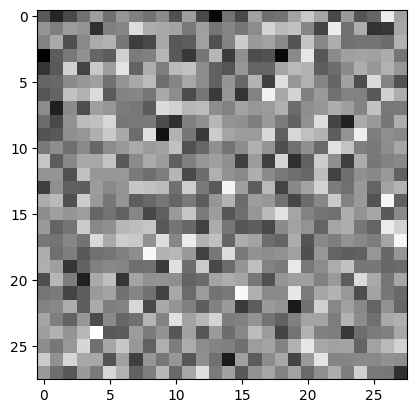

In [25]:
plt.imshow(gen_imgs[0],cmap='gray');

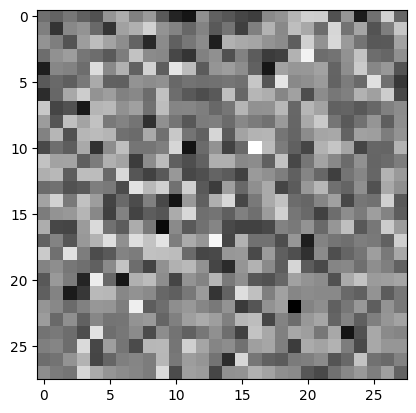

In [26]:
plt.imshow(gen_imgs[1],cmap='gray');

Discriminator Training


In [27]:
criterion = nn.BCELoss()
d_optimizer =torch.optim.Adam(D.parameters(),lr=0.0002)

In [28]:
g_optimizer=torch.optim.Adam(G.parameters(),lr=0.0002)

In [29]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()
def train_discriminator(images):
  #Create the Labels which are later used as input for the BCE loss
  real_labels =torch.ones(batch_size,1).to(device)
  fake_labels =torch.zeros(batch_size,1).to(device)

  #loss for real images
  outputs =D(images)
  d_loss_real =criterion(outputs,real_labels)
  real_score =outputs

  #Loss for fake images
  z =torch.randn(batch_size,latent_size).to(device)
  fake_images = G(z)
  outputs =D(fake_images)
  d_loss_fake = criterion(outputs,fake_labels)
  fake_score =outputs

  #combine Losses
  d_loss =d_loss_real + d_loss_fake

  #Reset Gradients
  reset_grad()
  #Compute gradients
  d_loss.backward()

  #Adjust the Parameters using backprop
  d_optimizer.step()
  return d_loss,real_score,fake_score





Generator Training

In [30]:
def train_generator():
  #Generate fake images and Calculate loss
  z=torch.randn(batch_size,latent_size).to(device)
  fake_images=G(z)
  labels =torch.ones(batch_size,1).to(device)
  g_loss =criterion(D(fake_images),labels)

  #Backprop and Optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss,fake_images


Training model

In [31]:
import os
sample_dir ='samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

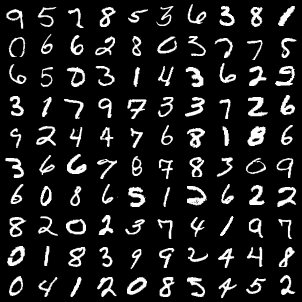

In [32]:
from IPython.display import Image
from torchvision.utils import save_image

#save some real images
for images,_ in data_loader:
  images =images.reshape(images.size(0),1,28,28)
  save_image(denorm(images),os.path.join(sample_dir,'real_images.png'),nrow=10)
  break
Image(os.path.join(sample_dir,'real_images.png'))

In [33]:
sample_vectors =torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
  fake_fname ='fake_images-{0:0=4d}.png'.format(index)
  print('Saving',fake_fname)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=10)

#Befor Training
save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
%%time
num_epochs =300
total_step =len(data_loader)
d_losses,g_losses,real_scores,fake_scores = [],[],[],[]

for epoch in range(num_epochs):
  for i ,(images,_) in enumerate(data_loader):
    #load a Batch & transform to vectors
    images = images.reshape(batch_size,-1).to(device)

    #Train the discriminator and generatoe
    d_loss,real_score,fake_score =train_discriminator(images)
    g_loss,fake_images =train_generator()

    #Ispect the losses
    if(i+1) %200==0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch[{}/{}],Step [{}/{}],d_loss:{:.4f},g_loss:{:.4f},D(x):{:.2f},D(G(z)):{:.2f}'.format(epoch,num_epochs,i+1,total_step,d_loss.item(),g_loss.item(),real_score.mean().item(),fake_score.mean().item()))
  #Sample and Save Images
  save_fake_images(epoch+1)

In [ ]:
torch.save(G.state_dict(),'G.ckpt')
torch.save(D.state.dict(),'D.ckpt')

In [ ]:
Image('./samples/fake_images=0010.png')

In [ ]:
Image('./samples/fake_images-0050.png')

In [ ]:
Image('./samples/fake_images-0100.png')

In [ ]:
Image('./samples/fake_images-0300.png')

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname ='gans_training.avi'
files =[os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out=cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),8,(302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

Visualizing

In [ ]:
plt.plot(d_losses,'-')
plt.plot(g_losses,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminatoe','Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score','Fake Score'])
plt.title('Scores');

MOdel Interpret and Save